In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import astropy.units as u

from IPython.display import clear_output

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

In [3]:
with fits.open('/data2/lsajkov/mpdg/data/DESI/edr_galaxy_stellarmass_lineinfo_v1.0.fits') as edr_cat:
    edr_cat = Table(edr_cat[1].data)

In [4]:
edr_cat.keys()

['TARGETID',
 'Z',
 'ZERR',
 'TARGET_RA',
 'TARGET_DEC',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'GAIA_PHOT_G_MEAN_MAG',
 'OII3726_CENTER',
 'OII3726_CENTERERR',
 'OII3726_FLUX',
 'OII3726_FLUXERR',
 'OII3726_SIGMA',
 'OII3726_SIGMAERR',
 'OII3726_CONT',
 'OII3726_CONTERR',
 'OII3726_EW',
 'OII3726_EWERR',
 'OII3729_CENTER',
 'OII3729_CENTERERR',
 'OII3729_FLUX',
 'OII3729_FLUXERR',
 'OII3729_SIGMA',
 'OII3729_SIGMAERR',
 'OII3729_CONT',
 'OII3729_CONTERR',
 'OII3729_EW',
 'OII3729_EWERR',
 'NEIII3869_CENTER',
 'NEIII3869_CENTERERR',
 'NEIII3869_FLUX',
 'NEIII3869_FLUXERR',
 'NEIII3869_SIGMA',
 'NEIII3869_SIGMAERR',
 'NEIII3869_CONT',
 'NEIII3869_CONTERR',
 'NEIII3869_EW',
 'NEIII3869_EWERR',
 'NEIII39

In [65]:
targetID = edr_cat['TARGETID']

flux_r = edr_cat['FLUX_R']
r_snr  = edr_cat['FLUX_R'] * np.sqrt(edr_cat['FLUX_IVAR_R'])

flux_g = edr_cat['FLUX_G']
g_snr  = edr_cat['FLUX_G'] * np.sqrt(edr_cat['FLUX_IVAR_G'])

flux_z = edr_cat['FLUX_Z']
z_snr  = edr_cat['FLUX_Z'] * np.sqrt(edr_cat['FLUX_IVAR_Z'])

g_mag     = 22.5 - 2.5 * np.log10(edr_cat['FLUX_G']) #original in nanomaggys
g_mag_err = 2.5 / (edr_cat['FLUX_G'] * np.sqrt(edr_cat['FLUX_IVAR_G']))

r_mag     = 22.5 - 2.5 * np.log10(edr_cat['FLUX_R']) #original in nanomaggys
r_mag_err = 2.5 / (edr_cat['FLUX_R'] * np.sqrt(edr_cat['FLUX_IVAR_R']))

z_mag     = 22.5 - 2.5 * np.log10(edr_cat['FLUX_Z']) #original in nanomaggys
z_mag_err = 2.5 / (edr_cat['FLUX_Z'] * np.sqrt(edr_cat['FLUX_IVAR_Z']))

gr_color     = g_mag - r_mag
gr_color_err = np.sqrt(g_mag_err ** 2 + r_mag_err ** 2)

rz_color     = r_mag - z_mag
rz_color_err = np.sqrt(r_mag_err ** 2 + z_mag_err ** 2)

gz_color     = g_mag - z_mag
gz_color_err = np.sqrt(g_mag_err ** 2 + z_mag_err ** 2)

log_mstar     = np.log10(edr_cat['SED_MASS']) #original in solar masses
log_mstar_err = edr_cat['SED_MASSERR']/(edr_cat['SED_MASS'] * np.log(10))

redshift = edr_cat['Z']

clear_output()

Text(0, 0.5, 'Count')

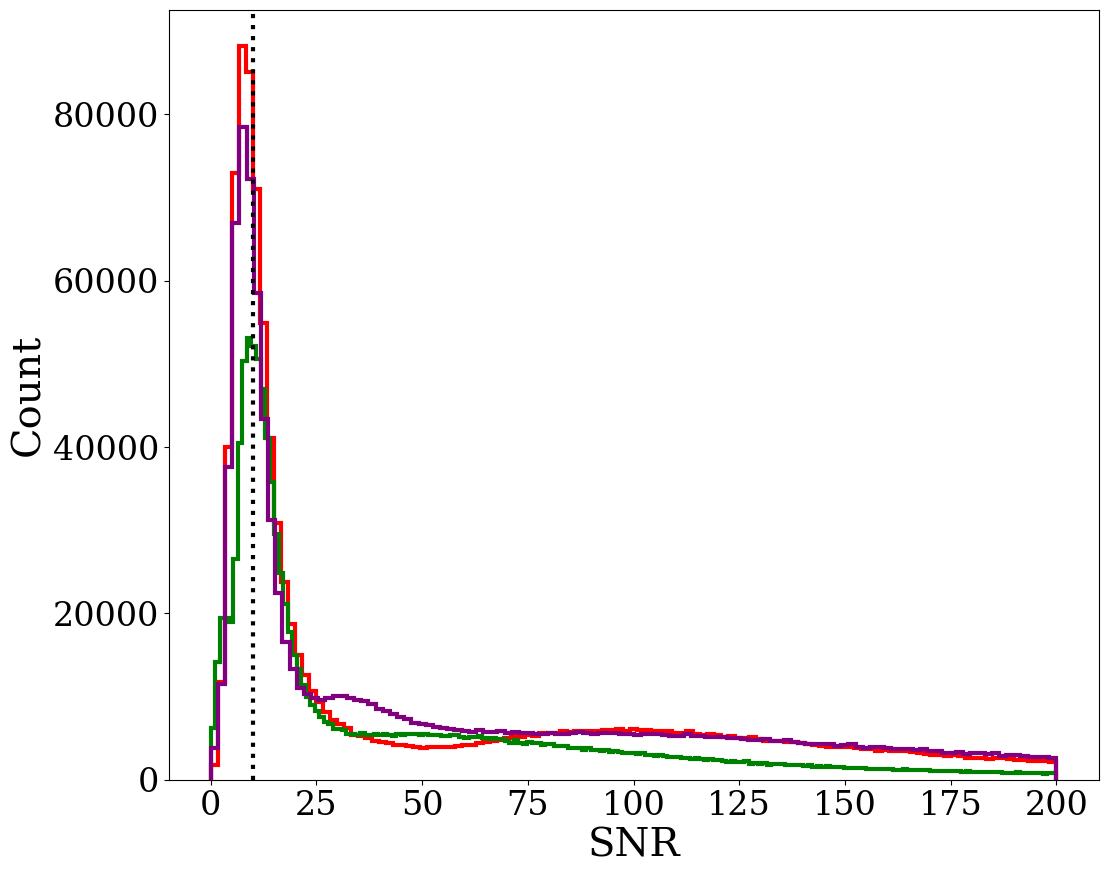

In [53]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(r_snr[(r_snr < 200) & (r_snr > 0)],
        bins = 'auto', histtype = 'step', color = 'red', linewidth = 3)
ax.hist(g_snr[(g_snr < 200) & (g_snr > 0)],
        bins = 'auto', histtype = 'step', color = 'green', linewidth = 3)
ax.hist(z_snr[(z_snr < 200) & (z_snr > 0)],
        bins = 'auto', histtype = 'step', color = 'purple', linewidth = 3)

ax.axvline(10, color = 'black', linestyle = ':', linewidth = 3)

ax.set_xlabel('SNR')
ax.set_ylabel('Count')

In [54]:
#quality cuts
snr_thresh = 10
snr_cut = (r_snr >= snr_thresh) &\
          (g_snr >= snr_thresh) &\
          (z_snr >= snr_thresh)

redshift_cut = (redshift >= 0) & (redshift < 10)

color_lo = -3
color_hi = 3
color_cut = (gr_color > color_lo) & (gr_color < color_hi) &\
            (gz_color > color_lo) & (gz_color < color_hi) &\
            (rz_color > color_lo) & (rz_color < color_hi)

log_mstar_lo = 6
log_mstar_hi = 12
log_mstar_cut = (log_mstar > log_mstar_lo) & (log_mstar < log_mstar_hi)

morphtype_cut = edr_cat['MORPHTYPE'] != 'PSF'

In [55]:
#define primary targeting region
def gr_color_condition(gr_color, r_mag):
    
    return (gr_color + 3 * r_mag) < 62
    # return (gr_color + 0.3 * r_mag) < 6.35

def rz_color_condition(rz_color, r_mag):

    return (rz_color + 0.25 * r_mag) < 5.85

def gz_color_condition(gz_color, r_mag):

    return (gz_color + 0.35 * r_mag) < 8

In [56]:
prt_gr_color_cut = gr_color_condition(gr_color,
                                      r_mag)

prt_rz_color_cut = rz_color_condition(rz_color,
                                      r_mag)

prt_gz_color_cut = gz_color_condition(gz_color,
                                      r_mag)

prt_mag_cut = r_mag > 18

/var/tmp/lsajkov/ipykernel_258529/121738950.py:4: RuntimeWarning: invalid value encountered in add
  return (gr_color + 3 * r_mag) < 62
/var/tmp/lsajkov/ipykernel_258529/121738950.py:13: RuntimeWarning: invalid value encountered in add
  return (gz_color + 0.35 * r_mag) < 8


In [57]:
total_cut = snr_cut &\
            redshift_cut &\
            color_cut &\
            log_mstar_cut &\
            morphtype_cut &\
            prt_gr_color_cut &\
            prt_rz_color_cut &\
            prt_gz_color_cut &\
            prt_mag_cut

print('Grand total of cuts:')
print(f'{np.sum(total_cut)}/{len(total_cut)} (~{int(100 * np.sum(total_cut)/len(total_cut))}%)')

Grand total of cuts:
90753/1223269 (~7%)


Text(0, 0.5, 'Count')

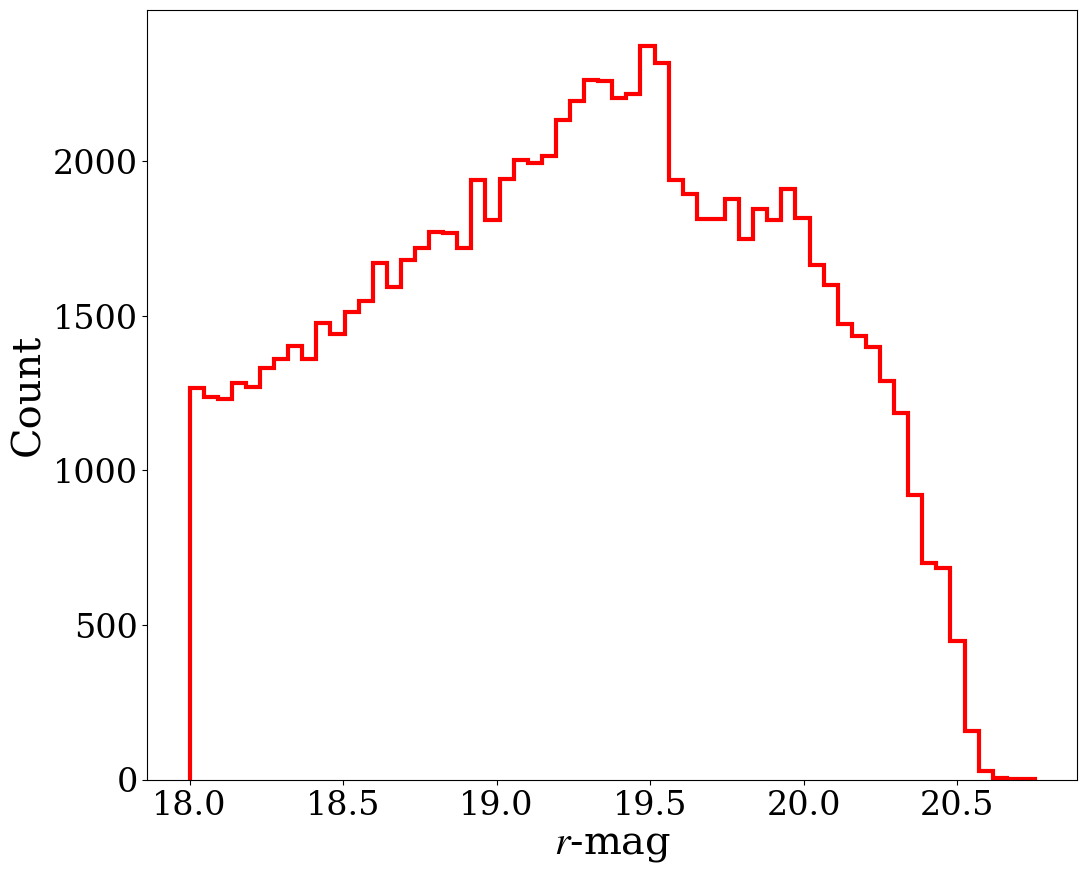

In [58]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(r_mag[total_cut],
        bins = 'auto', histtype = 'step', color = 'red', linewidth = 3)

# ax.hist(g_mag[total_cut],
#         bins = 'auto', histtype = 'step', color = 'green', linewidth = 3)

# ax.hist(z_mag[total_cut],
#         bins = 'auto', histtype = 'step', color = 'purple', linewidth = 3)

ax.set_xlabel('$r$-mag')
ax.set_ylabel('Count')

Text(0.5, 0, 'redshift')

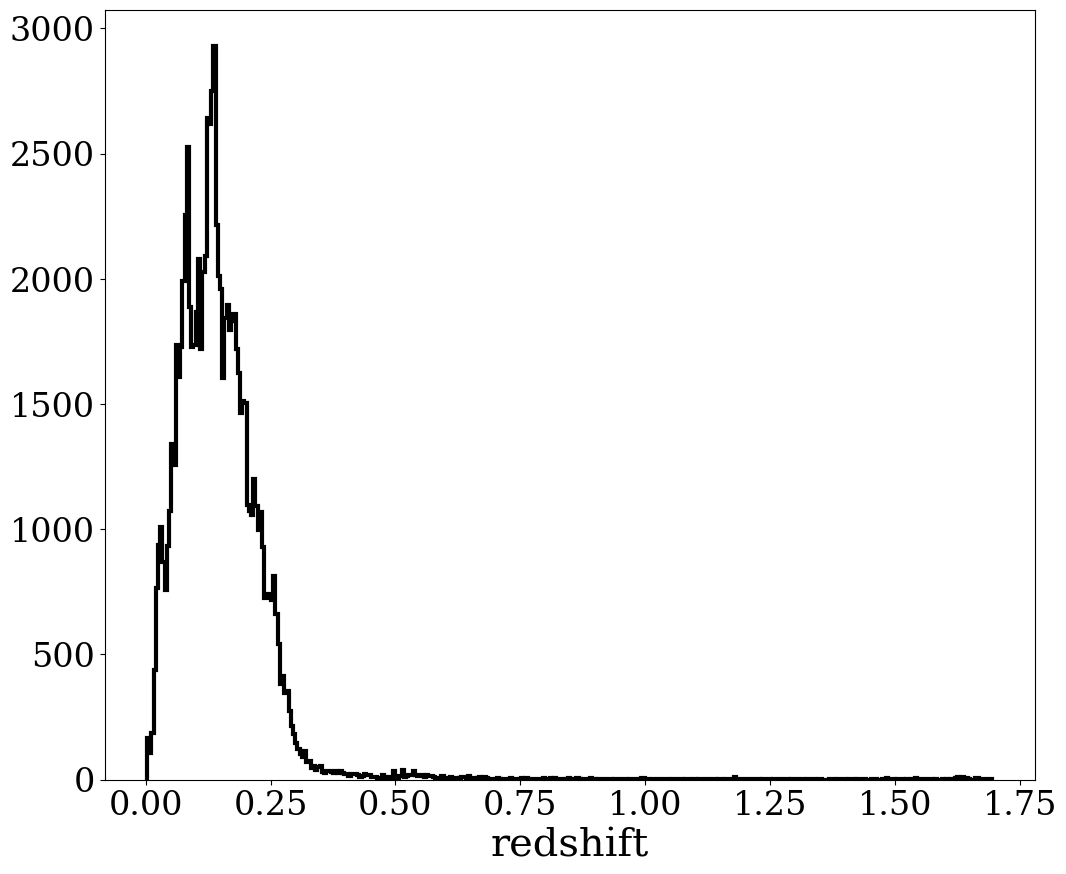

In [59]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(redshift[total_cut],
        bins = 'auto', histtype = 'step', color = 'black', linewidth = 3)

ax.set_xlabel('redshift')

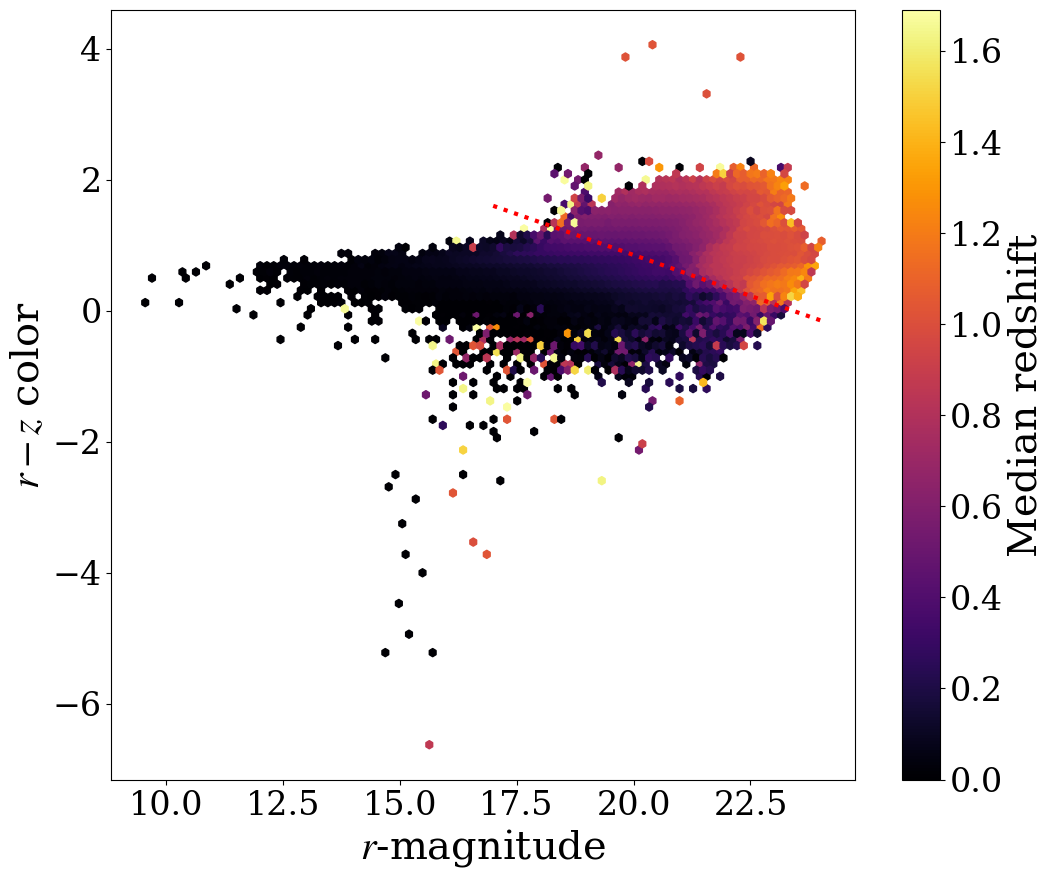

In [60]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(r_mag[snr_cut],
          rz_color[snr_cut], C = redshift[snr_cut],
          reduce_C_function = np.median,
          cmap = 'inferno')

fig.colorbar(mappable = hxb,
             label = 'Median redshift')

ax.set_xlabel('$r$-magnitude')
ax.set_ylabel('$r-z$ color')

ax.plot(np.array([17, 24]),
        5.85 - 0.25 * np.array([17, 24]), color = 'red',
        linestyle = ':', linewidth = 3)

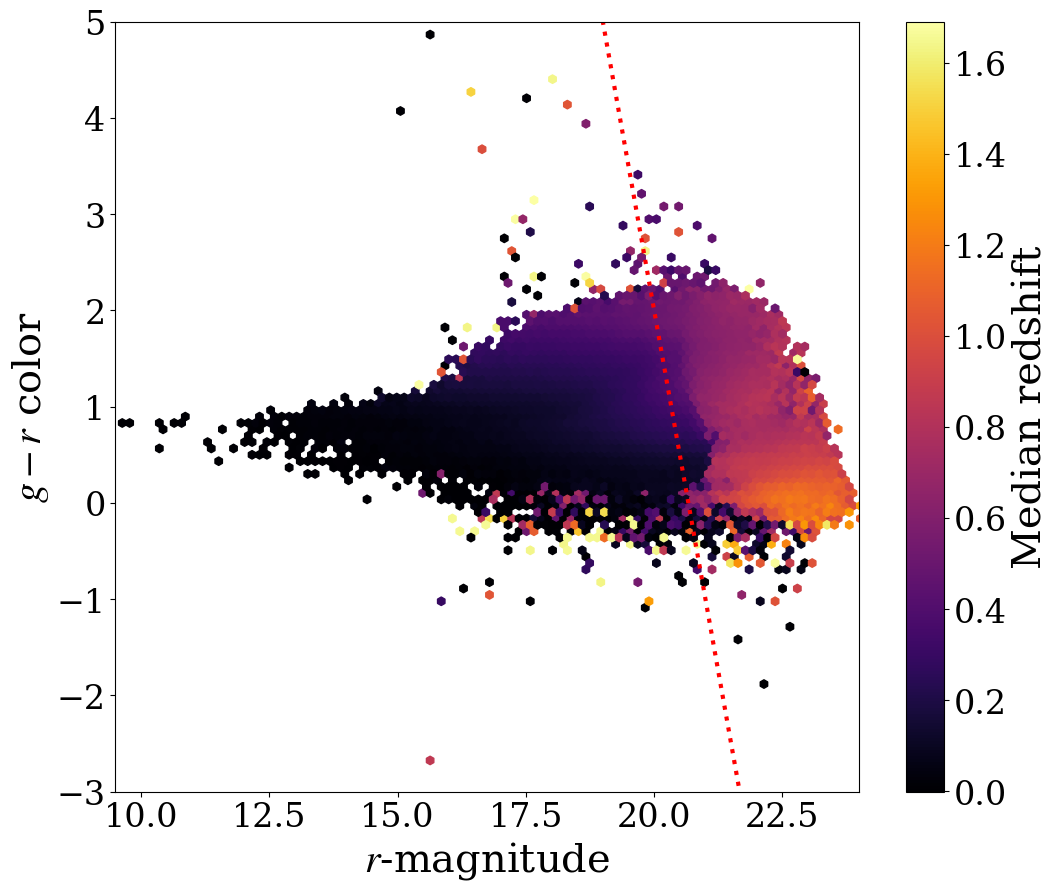

In [61]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(r_mag[snr_cut],
          gr_color[snr_cut], C = redshift[snr_cut],
          reduce_C_function = np.median,
          cmap = 'inferno')

fig.colorbar(mappable = hxb,
             label = 'Median redshift')

ax.set_xlabel('$r$-magnitude')
ax.set_ylabel('$g-r$ color')

ax.set_xlim(9.5, 24)
ax.set_ylim(-3, 5)

ax.plot(np.array([13, 24]),
        62 - 3 * np.array([13, 24]), color = 'red',
        linestyle = ':', linewidth = 3)

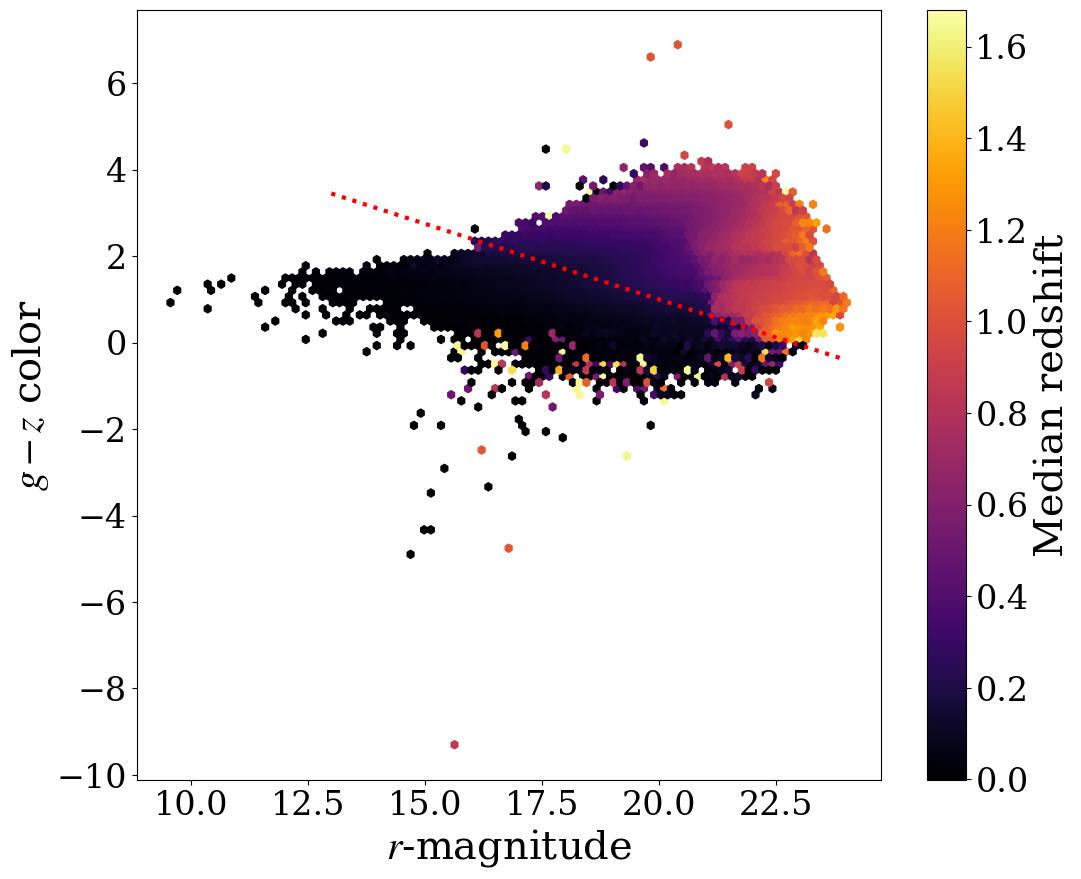

In [62]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(r_mag[snr_cut],
          gz_color[snr_cut], C = redshift[snr_cut],
          reduce_C_function = np.median,
          cmap = 'inferno')

fig.colorbar(mappable = hxb,
             label = 'Median redshift')

ax.set_xlabel('$r$-magnitude')
ax.set_ylabel('$g-z$ color')

ax.plot(np.array([13, 24]),
        8 - 0.35 * np.array([13, 24]), color = 'red',
        linestyle = ':', linewidth = 3)

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_258529/4053250834.py:7: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('log($M_*/M_{\odot}$)')


Text(0.5, 0, 'log($M_*/M_{\\odot}$)')

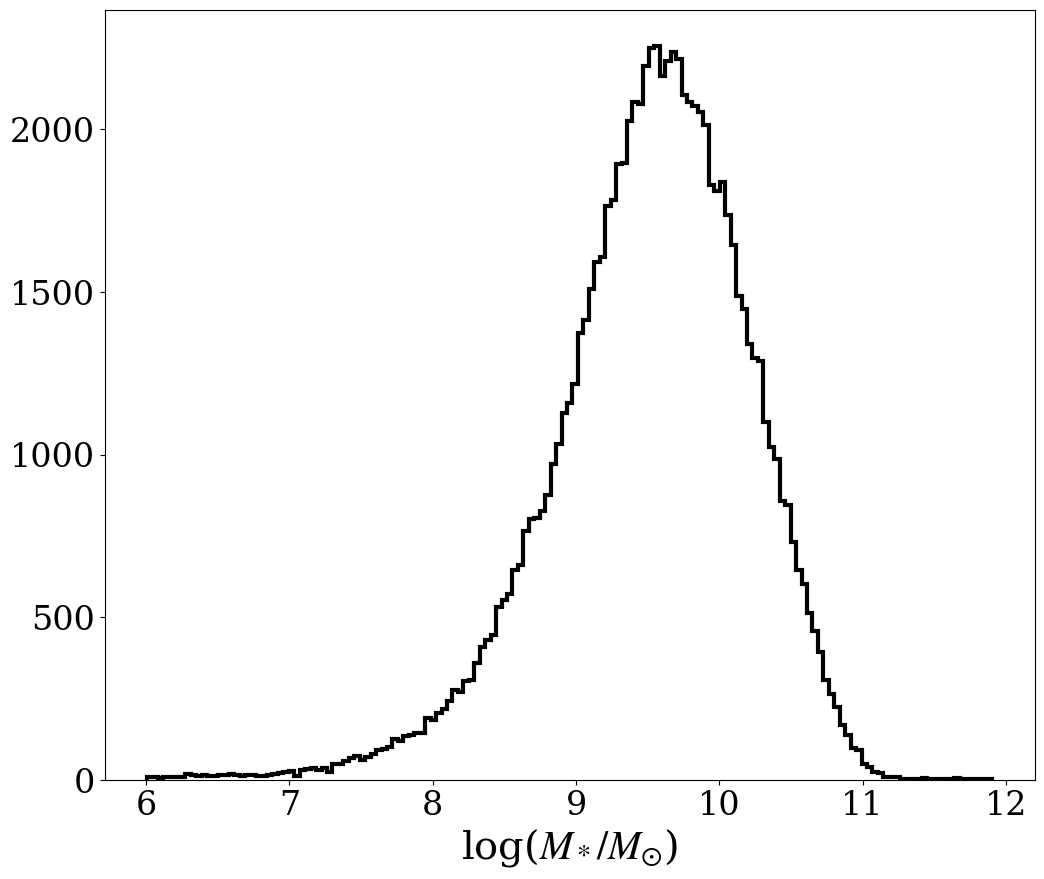

In [63]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(log_mstar[total_cut],
        bins = 'auto', histtype = 'step', color = 'black', linewidth = 3)

ax.set_xlabel('log($M_*/M_{\odot}$)')

<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_258529/1726589185.py:9: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('log($M_*/M_{\odot}$)')


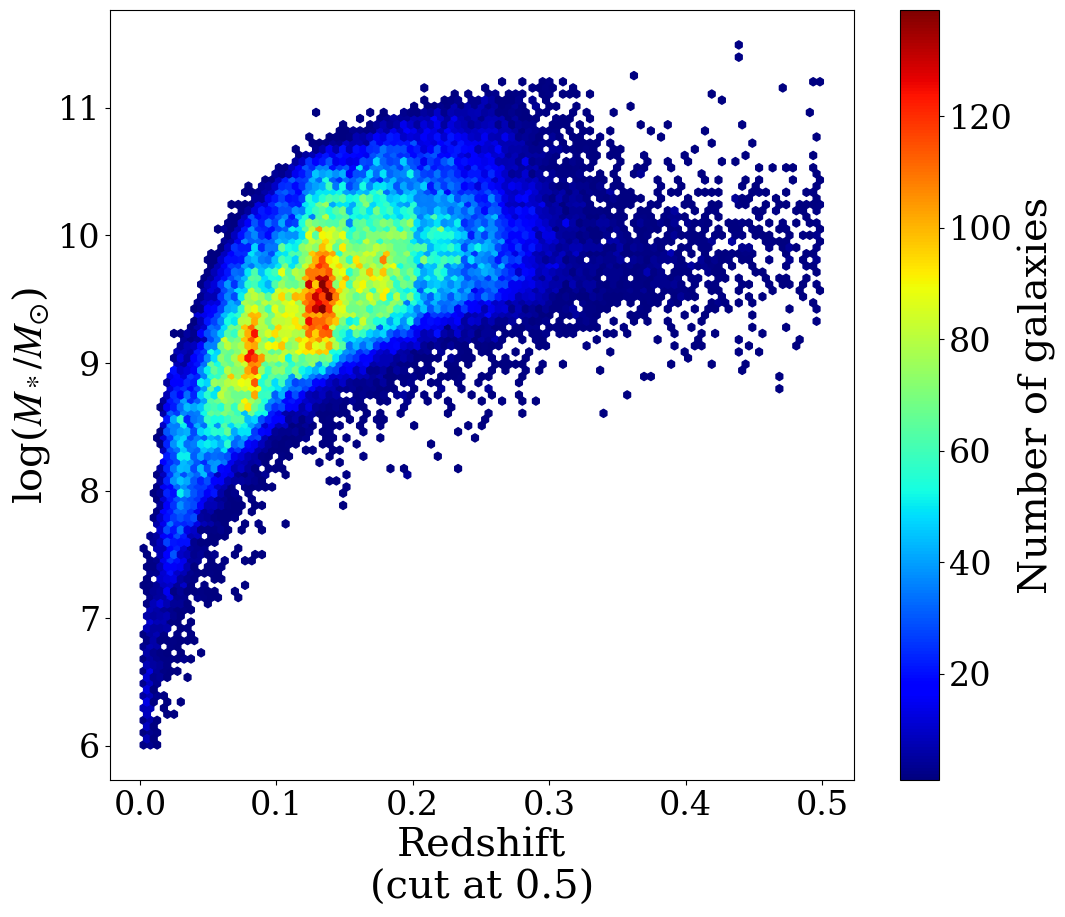

In [44]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(redshift[(total_cut) & (redshift < 0.5)],
          log_mstar[total_cut  & (redshift < 0.5)],
          mincnt = 1, cmap = 'jet')

ax.set_xlabel('Redshift\n(cut at 0.5)')
ax.set_ylabel('log($M_*/M_{\odot}$)')

fig.colorbar(mappable = hxb, ax = ax,
             label = 'Number of galaxies')

In [66]:
DESI_SOM_training_catalog = Table([targetID[total_cut],
                                   g_mag[total_cut], g_mag_err[total_cut],
                                   r_mag[total_cut], r_mag_err[total_cut],
                                   z_mag[total_cut], z_mag_err[total_cut],
                                   gr_color[total_cut], gr_color_err[total_cut],
                                   rz_color[total_cut], rz_color_err[total_cut],
                                   gz_color[total_cut], gz_color_err[total_cut],
                                   log_mstar[total_cut], log_mstar_err[total_cut],
                                   redshift[total_cut]
                                   ],
                          names = ['targetID',
                                   'g_mag', 'g_mag_err',
                                   'r_mag', 'r_mag_err',
                                   'z_mag', 'z_mag_err',
                                   'gr_col', 'gr_col_err',
                                   'rz_col', 'rz_col_err',
                                   'gz_col', 'gz_col_err',
                                   'log_mstar', 'log_mstar_err',
                                   'redshift'])

In [67]:
DESI_SOM_training_catalog.write('/data2/lsajkov/mpdg/data_products/DESI/DESI_SOM_catalog.fits')